In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_moons, make_blobs

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.optimizer import SGD
from micrograd.visualize import visualize_computational_graph

In [3]:
np.random.seed(732)
random.seed(732)

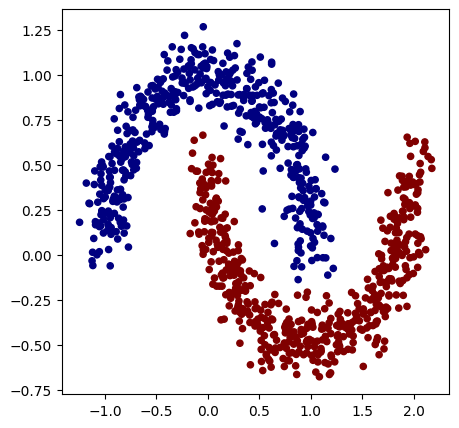

In [4]:
# make up a dataset
X, y = make_moons(n_samples=1000, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
model = MLP(2, [16, 16, 1], act=True)
optimizer = SGD(model.parameters(), learning_rate=0.5, decay_rate=0.01)
print(model)
print(optimizer)

MLP: [Layer: [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer: [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer: [ReLUNeuron(16)]]
SGD Optimizer, num_params=337, lr=0.5, decay_rate=0.01


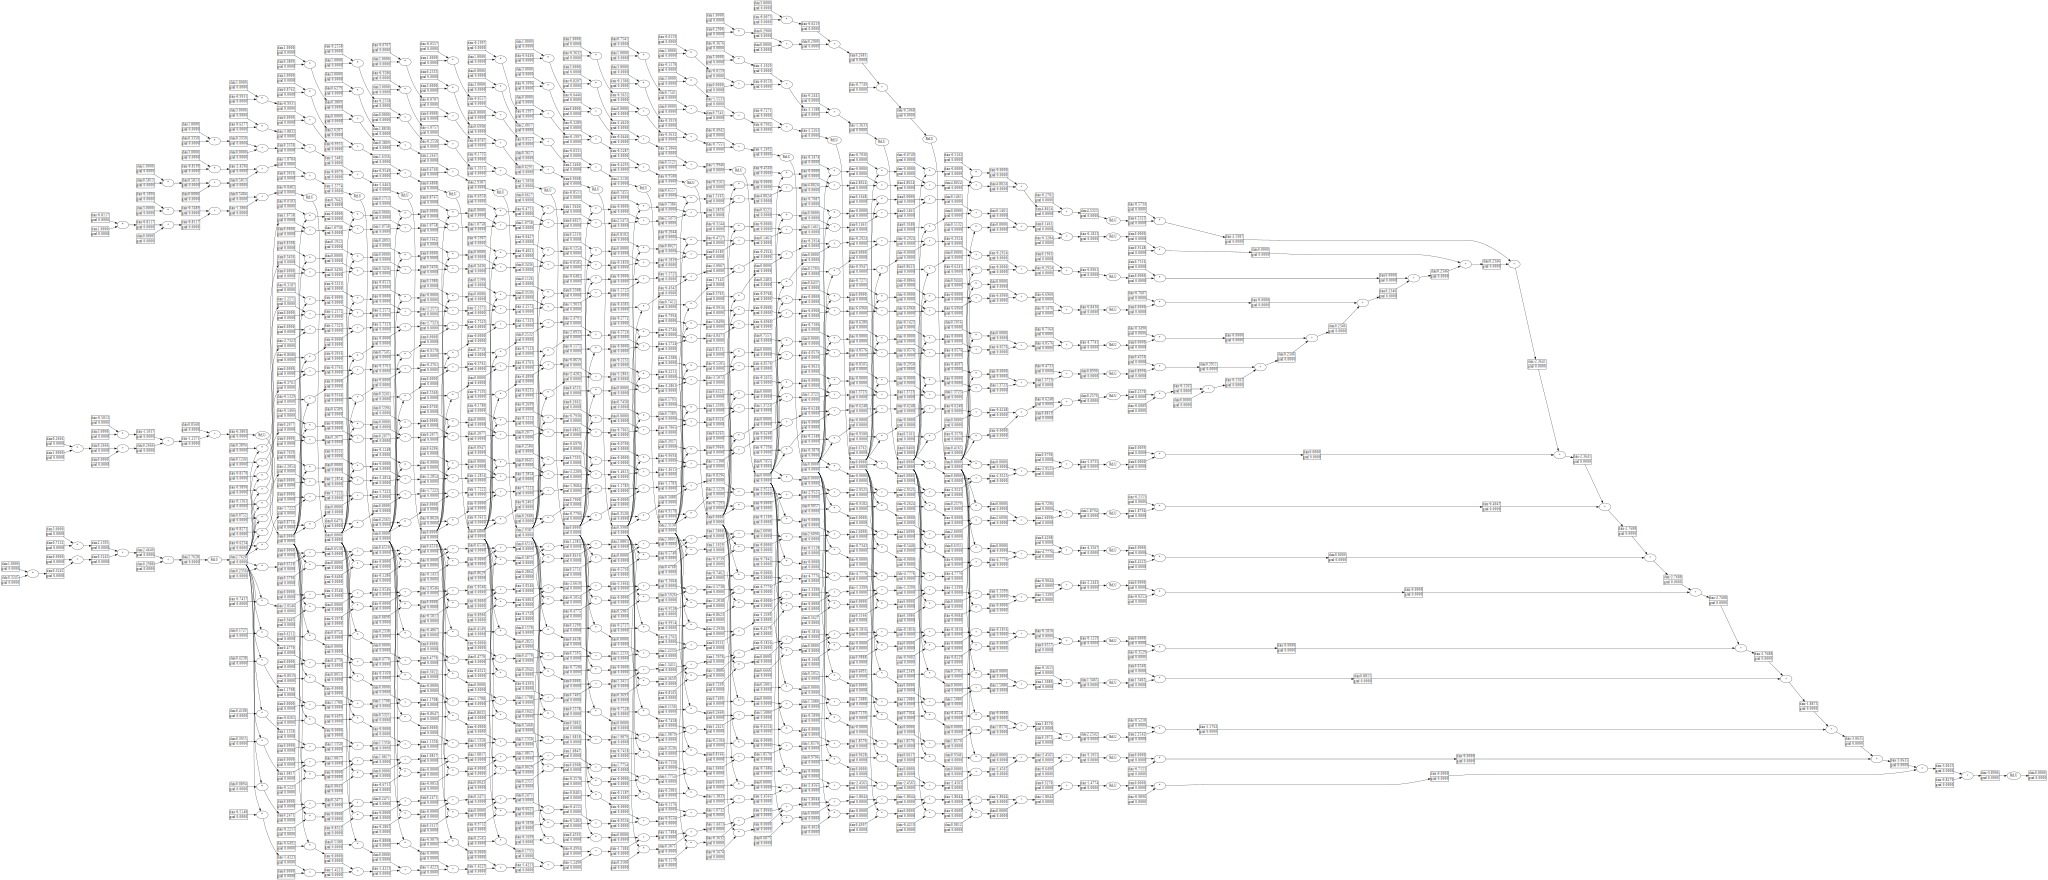

In [6]:
fake_input = [1.0, 3.0]
out = model(fake_input)
visualize_computational_graph(out)

In [7]:
# loss function
def train(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [8]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = train(batch_size=100)
    
    # backward
    optimizer.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    optimizer.step()
    
    if k % 1 == 0:
        print(f"step: {k} loss: {total_loss.data}, accuracy: {acc*100}%")

step: 0 loss: 0.6835650422192331, accuracy: 91.0%
step: 1 loss: 0.7861365930033208, accuracy: 86.0%
step: 2 loss: 0.6125187684515652, accuracy: 90.0%
step: 3 loss: 0.6969816037428302, accuracy: 91.0%
step: 4 loss: 0.6096598269288167, accuracy: 90.0%
step: 5 loss: 0.5923158958748272, accuracy: 91.0%
step: 6 loss: 0.6004745013521425, accuracy: 88.0%
step: 7 loss: 0.6206556851501052, accuracy: 91.0%
step: 8 loss: 0.7000395469073046, accuracy: 83.0%
step: 9 loss: 0.6369143612966419, accuracy: 95.0%
step: 10 loss: 0.8048374058492063, accuracy: 77.0%
step: 11 loss: 0.614526283122319, accuracy: 93.0%
step: 12 loss: 0.6305786175171636, accuracy: 89.0%
step: 13 loss: 0.6571324207698279, accuracy: 91.0%
step: 14 loss: 0.5138767574683277, accuracy: 89.0%
step: 15 loss: 0.6518018660649701, accuracy: 87.0%
step: 16 loss: 0.6122490109224623, accuracy: 92.0%
step: 17 loss: 0.6185012301687699, accuracy: 92.0%
step: 18 loss: 0.6644235861504683, accuracy: 89.0%
step: 19 loss: 0.6228255809813196, accurac

(-1.678833218099631, 2.071166781900369)

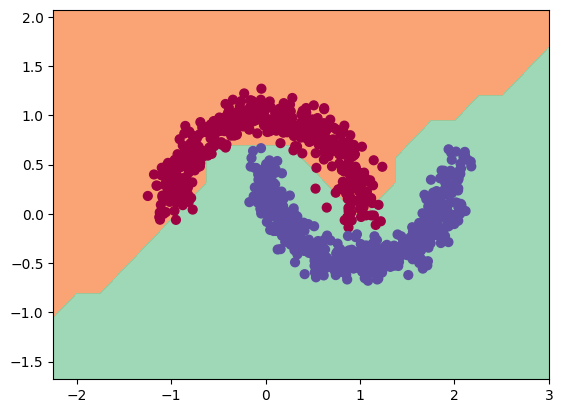

In [9]:

# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())